In [53]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.seasonal import STL

# Analisi esplorativa 

In [41]:
data = pd.read_csv('Time_series/sp500_stocks.csv')
data.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,46.422302,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,46.131523,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,46.785759,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,46.819294,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,47.149204,70.501671,70.501671,69.648827,69.974915,4073337.0


C:\Users\lucab\AppData\Local\Temp\ipykernel_18384\1083372151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])


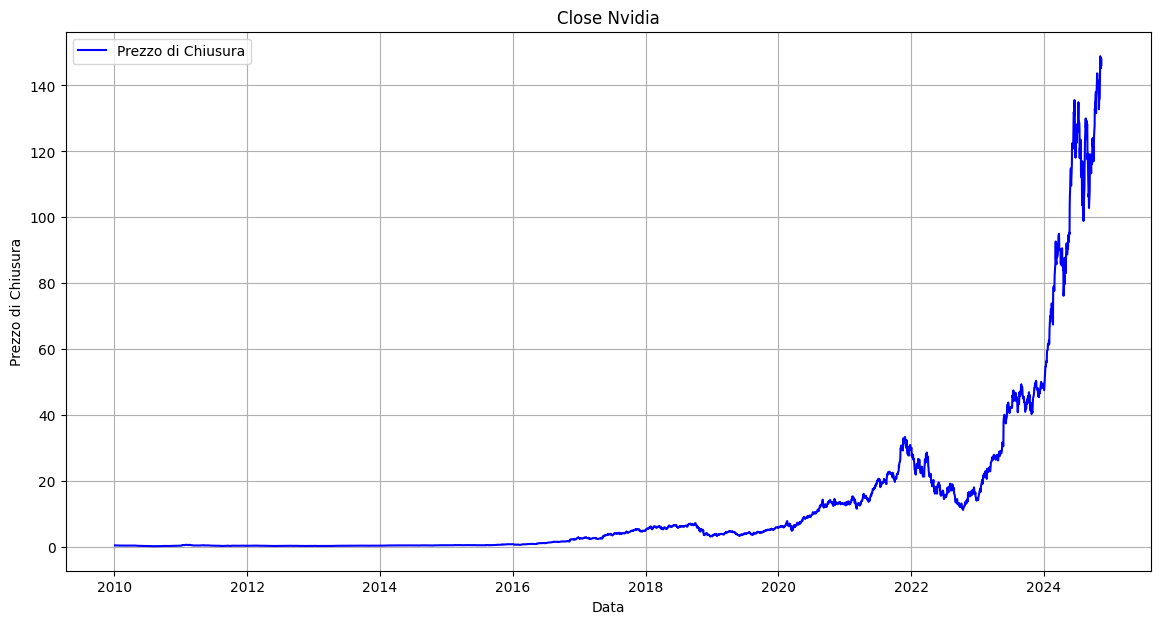

In [58]:
# Filtrare i dati per il simbolo 'NVDA'
nvda_data = data[data['Symbol'] == 'NVDA']

# Convertire la colonna 'Date' in formato datetime
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])

# Ordinare i dati per data
nvda_data = nvda_data.sort_values(by='Date')

# Tracciare il grafico dei prezzi di chiusura
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo di Chiusura', color='blue')
plt.title('Close Nvidia')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.grid(True)
plt.legend()
plt.show()

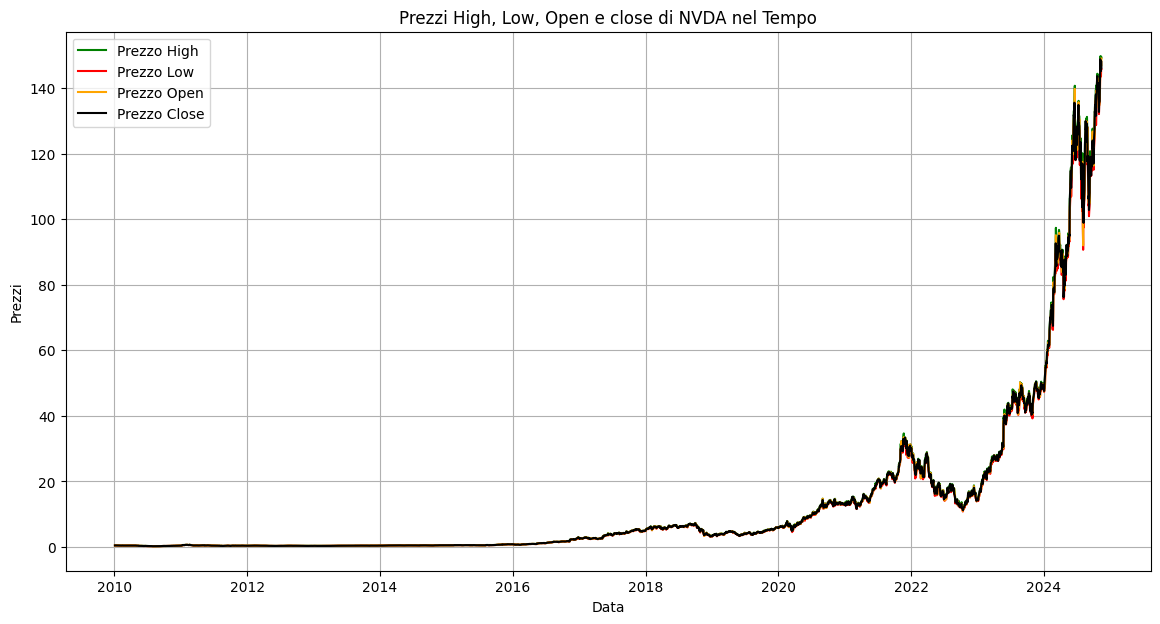

In [43]:
    # Tracciare il grafico dei prezzi di High, Low e Open
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['High'], label='Prezzo High', color='green')
plt.plot(nvda_data['Date'], nvda_data['Low'], label='Prezzo Low', color='red')
plt.plot(nvda_data['Date'], nvda_data['Open'], label='Prezzo Open', color='orange')
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo Close', color='black')
plt.title('Prezzi High, Low, Open e close di NVDA nel Tempo')
plt.xlabel('Data')
plt.ylabel('Prezzi')
plt.grid(True)
plt.legend()
plt.show()

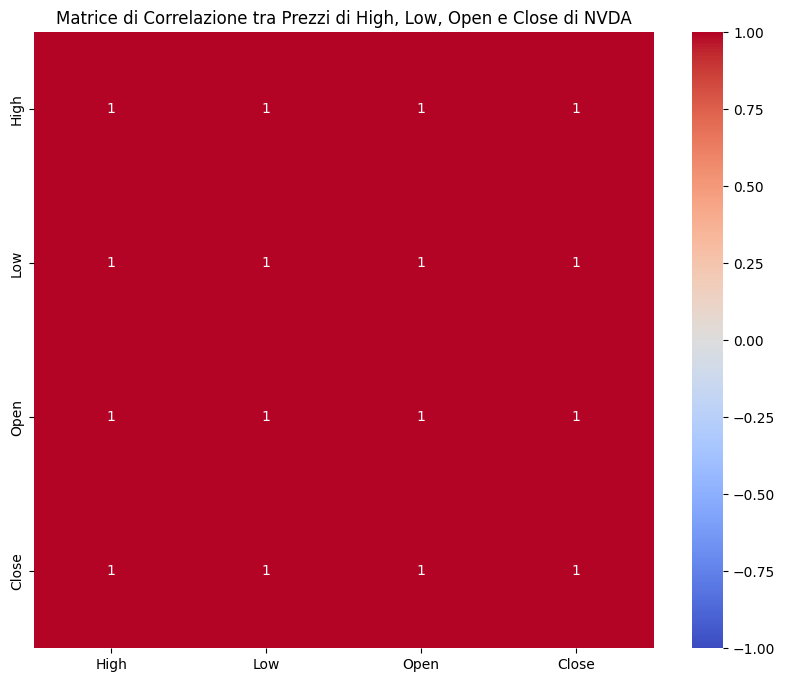

Statistiche descrittive per High, Low, Open e Close:

              High          Low         Open        Close
count  3742.000000  3742.000000  3742.000000  3742.000000
mean     13.176416    12.683224    12.939140    12.941507
std      26.196581    25.193727    25.727914    25.715832
min       0.226250     0.216250     0.218000     0.222000
25%       0.448188     0.433875     0.442313     0.441312
50%       3.490875     3.333375     3.411625     3.423000
75%      13.644625    13.190312    13.446312    13.403937
max     149.770004   146.259995   149.050003   148.880005


In [44]:
# Calcolare la correlazione tra le variabili
correlation_matrix = nvda_data[['High', 'Low', 'Open', 'Close']].corr()

# Visualizzare la matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di Correlazione tra Prezzi di High, Low, Open e Close di NVDA')
plt.show()

# Stampare statistiche descrittive per confrontare i valori
print("Statistiche descrittive per High, Low, Open e Close:\n")
print(nvda_data[['High', 'Low', 'Open', 'Close']].describe())

Visto che le grandezze analizzate sono molto correlate tra di loro con una simile media e std, ci concentriamo sul prezzo di apertura(open) e chiusura(close), cercando di prevedere la differenza open-close, per cosservare quanto è conveniente vendere in quel giorno.

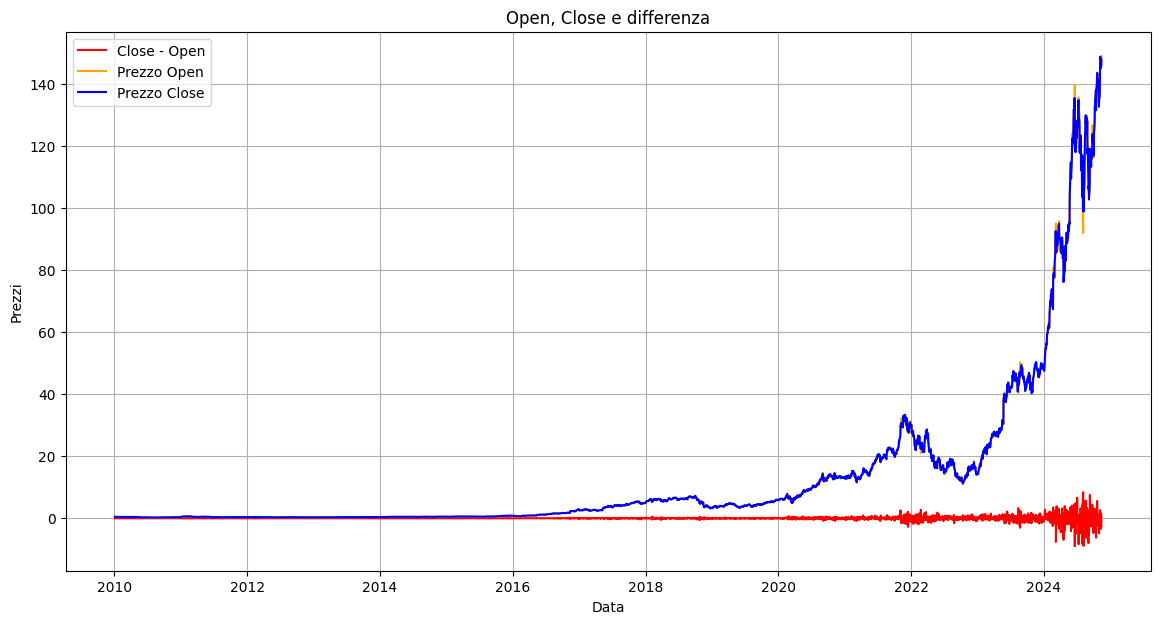

In [45]:
    # Tracciare il grafico dei prezzi di High, Low e Open
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close']-nvda_data['Open'], label='Close - Open', color='red')
plt.plot(nvda_data['Date'], nvda_data['Open'], label='Prezzo Open', color='orange')
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo Close', color='blue')
plt.title('Open, Close e differenza')
plt.xlabel('Data')
plt.ylabel('Prezzi')
plt.grid(True)
plt.legend()
plt.show()

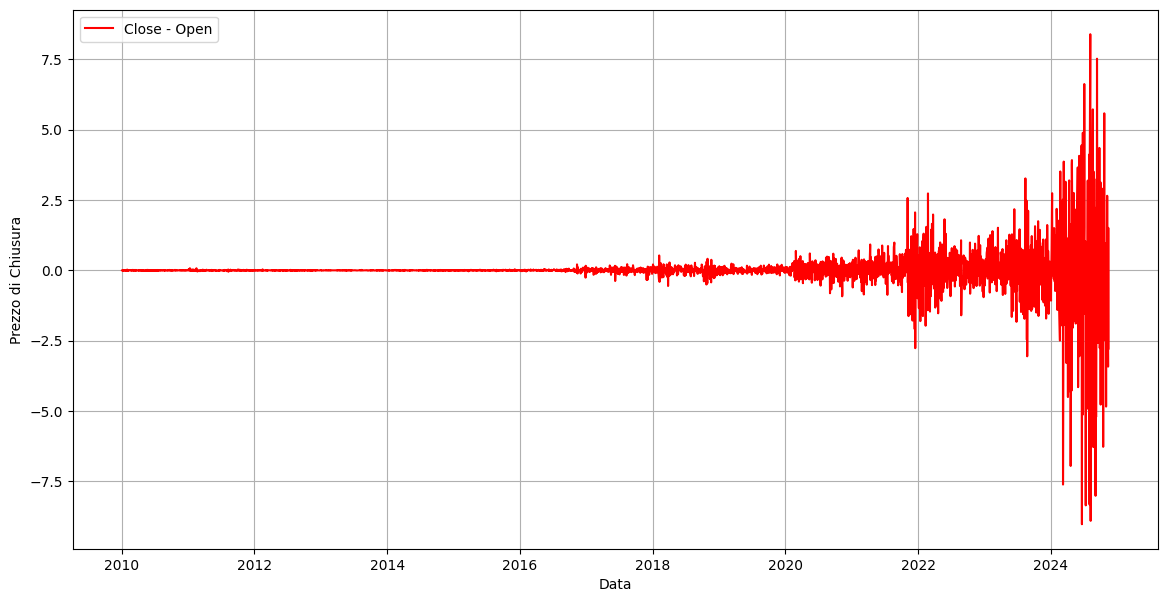

In [46]:
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close']-nvda_data['Open'], label='Close - Open', color='red')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.grid(True)
plt.legend()
plt.show()

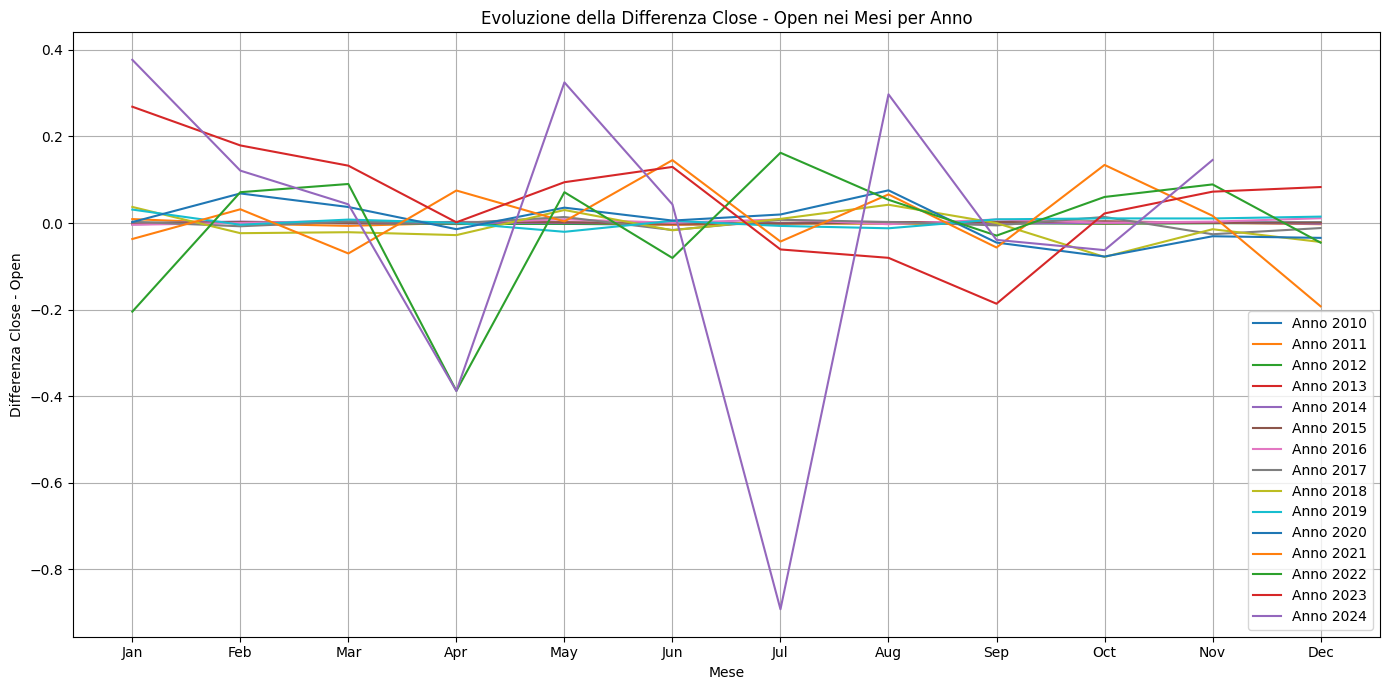

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Assumiamo che 'nvda_data' sia già definito con le colonne 'Date', 'Close', 'Open'

# Assicurati che 'Date' sia nel formato datetime
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])

# Calcolare la differenza Close - Open
nvda_data['Close-Open'] = nvda_data['Close'] - nvda_data['Open']

# Aggiungere colonne per anno e mese
nvda_data['Year'] = nvda_data['Date'].dt.year
nvda_data['Month'] = nvda_data['Date'].dt.month

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Creare il grafico
plt.figure(figsize=(14, 7))

# Per ogni anno, traccia la differenza Close-Open per i mesi
for year in nvda_data['Year'].unique():
    monthly_diff = nvda_data[nvda_data['Year'] == year].groupby('Month')['Close-Open'].mean()
    plt.plot(monthly_diff.index, monthly_diff.values, label=f'Anno {year}')

plt.xlabel('Mese')
plt.ylabel('Differenza Close - Open')
plt.title('Evoluzione della Differenza Close - Open nei Mesi per Anno')
plt.grid(True)
plt.legend()
plt.xticks(range(1, 13), labels=month_names)  # Aggiungi i numeri dei mesi (1-12)
plt.tight_layout()
plt.show()


## Decomposizione STL

In [72]:
import copy


nvda_data['Difference'] = nvda_data['Close'] - nvda_data['Open']
nvda_data.head()


nvda_data_copy = copy.deepcopy(nvda_data)
# Verifica che la colonna 'data' sia in formato datetime
nvda_data_copy['Date'] = pd.to_datetime(nvda_data['Date'])

# Imposta la colonna 'data' come indice del DataFrame
nvda_data_copy.set_index('Date', inplace=True)

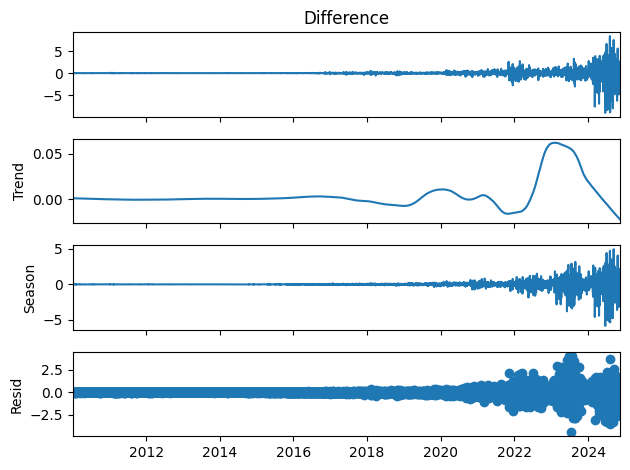

In [108]:
# Esegui la decomposizione STL
stl = STL(nvda_data_copy['Difference'], period=261)  # Modifica la stagionalità a seconda dei tuoi dati
result = stl.fit()

res = stl.fit()
fig = res.plot()



## Stationarity

In [ ]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value']
    df_test = adfuller(ts)
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])

In [ ]:
test_stationarity(nvda_data['Close']-nvda_data['Open'])

ADF statistic: -12.65478079389625
P-value: 1.3441122651800367e-23


## ACF and PACF graph

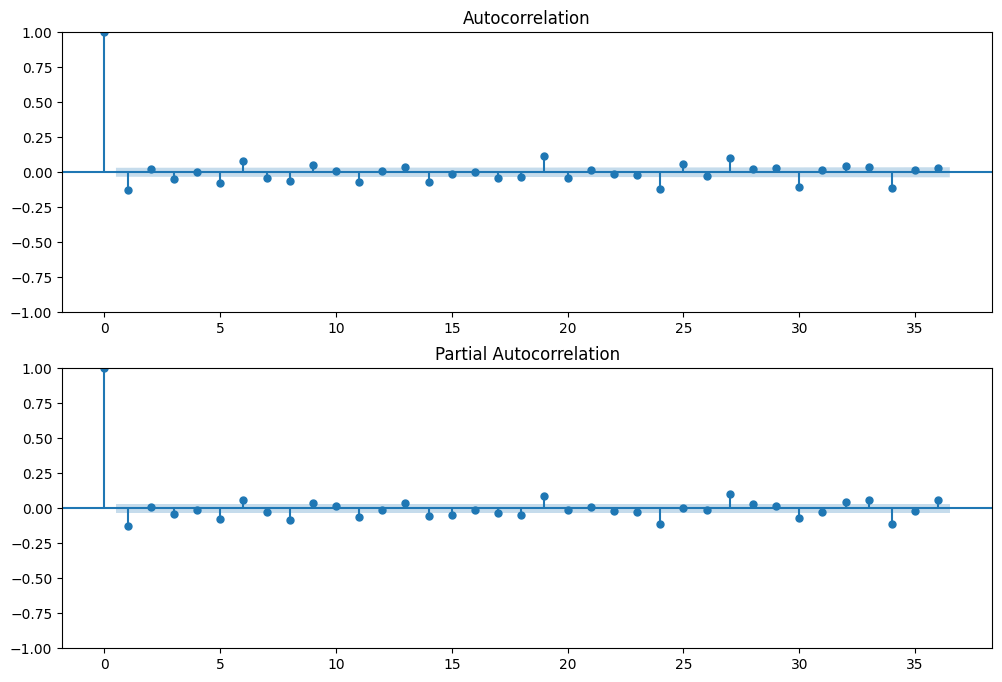

In [ ]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(nvda_data['Close']-nvda_data['Open'],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(nvda_data['Close']-nvda_data['Open'], ax=ax2)

# Fitting model

In [102]:
# Ordina il DataFrame per la colonna Date
nvda_data = nvda_data.sort_values(by='Date')

# Trova la data di cutoff per gli ultimi 21 giorni
cutoff_date = nvda_data['Date'].max() - pd.Timedelta(days=30)

# Crea il DataFrame train e test
train_data = nvda_data[nvda_data['Date'] <= cutoff_date]
test_data = nvda_data[nvda_data['Date'] > cutoff_date]

# Stampa o verifica i DataFrame
print("Train DataFrame:")
print(train_data.head())

print("\nTest DataFrame:")
print(test_data.head())
print(f"Lughezza test: {len(test_data)}")
print(f"Lughezza train: {len(train_data)}")
print(f"Lunghezza totale: {len(nvda_data)}")


Train DataFrame:
              Date Symbol  Adj Close    Close    High      Low     Open  \
1305958 2010-01-04   NVDA   0.423952  0.46225  0.4655  0.45275  0.46275   
1305959 2010-01-05   NVDA   0.430143  0.46900  0.4740  0.46050  0.46050   
1305960 2010-01-06   NVDA   0.432894  0.47200  0.4730  0.46425  0.46875   
1305961 2010-01-07   NVDA   0.424410  0.46275  0.4715  0.45925  0.46950   
1305962 2010-01-08   NVDA   0.425328  0.46375  0.4670  0.45625  0.45900   

              Volume  Difference  
1305958  800204000.0    -0.00050  
1305959  728648000.0     0.00850  
1305960  649168000.0     0.00325  
1305961  547792000.0    -0.00675  
1305962  478168000.0     0.00475  

Test DataFrame:
              Date Symbol   Adj Close       Close        High         Low  \
1309678 2024-10-15   NVDA  131.600006  131.600006  138.570007  128.740005   
1309679 2024-10-16   NVDA  135.720001  135.720001  136.619995  131.580002   
1309680 2024-10-17   NVDA  136.929993  136.929993  140.889999  136.869995 

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
model = auto_arima(train_data['Difference'], seasonal=False, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8178.989, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8261.483, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8206.340, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8208.395, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8196.480, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8197.281, Time=0.93 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8178.297, Time=1.75 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8194.683, Time=0.75 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=8178.859, Time=1.80 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=8184.804, Time=2.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8185.934, Time=1.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8195.771, Time=0.90 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=8168.833, Time=2.47 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=8164.987, Time=3.58 sec
 ARIMA(5,0,2)(0,0,0)[0]          

In [ ]:
residuals = model.resid()
model = ARIMA(train_data['Difference'], order=(5, 0, 2))
results_base = model.fit()

# Previsione dei residui
residuals = model.resid()
# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib

AttributeError: 'ARIMA' object has no attribute 'resid'